In [36]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.4
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.5.15
  [90137ffa] StaticArrays v1.9.14


In [39]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using StaticArrays

In [24]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [25]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [26]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…?,Measurem…?,Measurem…?,Measurem…?,Measurem…?
1,0.01,-0.005,40,40,0.001503±4.0e-5,-1.99502±2.4e-5,0.98897±0.00015,0.98895±0.00014,0.0296±0.003
2,0.05,-0.005,40,40,0.003408±3.7e-5,-1.95473±6.6e-5,0.94415±0.00078,0.94411±0.00078,0.0732±0.0068
3,0.1,-0.005,40,40,0.004852±3.9e-5,-1.90358±0.0001,0.8832±0.0022,0.8832±0.0022,0.1±0.01
4,0.125,-0.005,40,40,0.005432±2.8e-5,-1.87771±9.4e-5,0.8539±0.0018,0.8538±0.0018,0.0986±0.0064
5,0.15,-0.005,40,40,0.006022±3.3e-5,-1.85191±0.00013,0.8288±0.0015,0.8286±0.0015,0.0888±0.0058
6,0.175,-0.005,40,40,0.00642±3.6e-5,-1.82523±0.00012,0.7808±0.0045,0.7808±0.0045,0.163±0.015
7,0.2,-0.005,40,40,0.006888±3.3e-5,-1.7989±0.00013,0.7571±0.0026,0.757±0.0026,0.123±0.008
8,0.225,-0.005,40,40,0.007387±3.4e-5,-1.77226±0.00017,0.7242±0.003,0.7241±0.003,0.131±0.01
9,0.25,-0.005,40,40,0.007896±3.1e-5,-1.74519±0.00017,0.6901±0.0046,0.69±0.0046,0.13±0.013


In [27]:
fig = Figure(size=(800, 800))

generatePlot(
    data[[1]], :T, :Dxπ; fig,
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)
generatePlot(
    data[[2]], :T, :Dxπ; fig, fig_pos=(1,2),
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

generatePlot(
    data[[1]], :T, :P; fig, fig_pos=(2,1),
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)
generatePlot(
    data[[2]], :T, :P; fig, fig_pos=(2,2),
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

# save("temp-sweep-plots/Dx-P-plots.png", fig)
fig

ErrorException: type Missing has no field val

In [28]:
ungrouped_data = cleandata("../jobs/$jobname.results.json")

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…?,Measurem…?,Measurem…?,Measurem…?,Measurem…?
1,0.01,-0.005,40,40,0.001503±4.0e-5,-1.99502±2.4e-5,0.98897±0.00015,0.98895±0.00014,0.0296±0.003
2,0.05,-0.005,40,40,0.003408±3.7e-5,-1.95473±6.6e-5,0.94415±0.00078,0.94411±0.00078,0.0732±0.0068
3,0.1,-0.005,40,40,0.004852±3.9e-5,-1.90358±0.0001,0.8832±0.0022,0.8832±0.0022,0.1±0.01
4,0.125,-0.005,40,40,0.005432±2.8e-5,-1.87771±9.4e-5,0.8539±0.0018,0.8538±0.0018,0.0986±0.0064
5,0.15,-0.005,40,40,0.006022±3.3e-5,-1.85191±0.00013,0.8288±0.0015,0.8286±0.0015,0.0888±0.0058
6,0.175,-0.005,40,40,0.00642±3.6e-5,-1.82523±0.00012,0.7808±0.0045,0.7808±0.0045,0.163±0.015
7,0.2,-0.005,40,40,0.006888±3.3e-5,-1.7989±0.00013,0.7571±0.0026,0.757±0.0026,0.123±0.008
8,0.225,-0.005,40,40,0.007387±3.4e-5,-1.77226±0.00017,0.7242±0.003,0.7241±0.003,0.131±0.01
9,0.25,-0.005,40,40,0.007896±3.1e-5,-1.74519±0.00017,0.6901±0.0046,0.69±0.0046,0.13±0.013


In [29]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_P = fig[1,1] = Axis(
        fig,
        title="P vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        P_samples = read(observables, "P/samples")
        n = length(P_samples)
        init = 1
        lines!(
            ax_P,
            collect(init:n),
            P_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

DataFrameRow
 Row │ T        K        Lx     Ly     Mag              Energy            Dxπ            Dyπ            P           
     │ Float64  Float64  Int64  Int64  Measurem…?       Measurem…?        Measurem…?     Measurem…?     Measurem…?  
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────
  28 │    0.15    0.005     40     40  0.006228±4.7e-5  -1.84694±0.00014  0.0882±0.0096  0.0882±0.0096  0.757±0.012

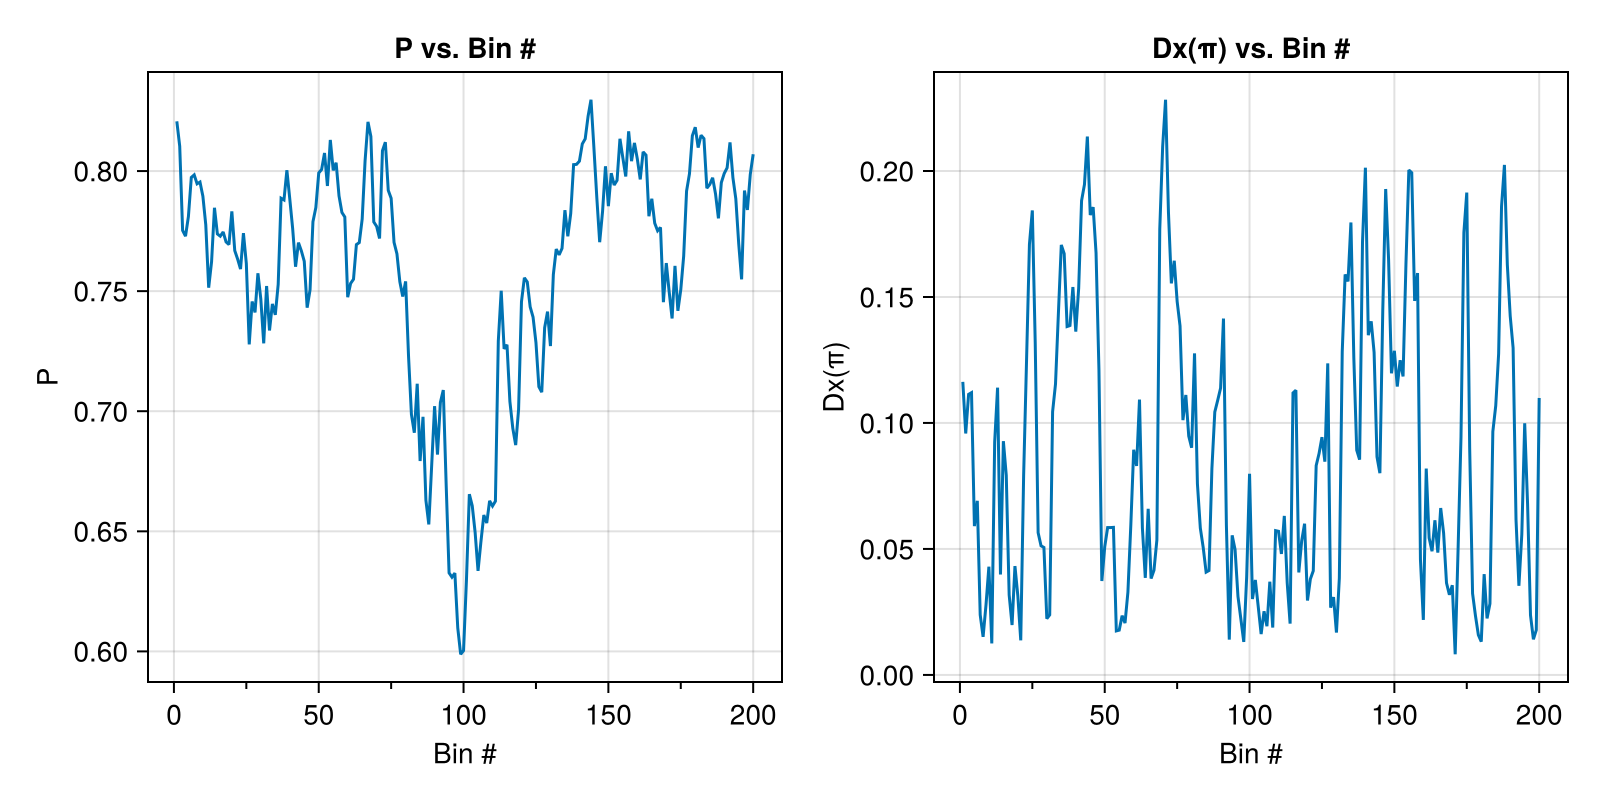

In [34]:
i = 28
print(ungrouped_data[i, :])
generate_mctime_plot(i)

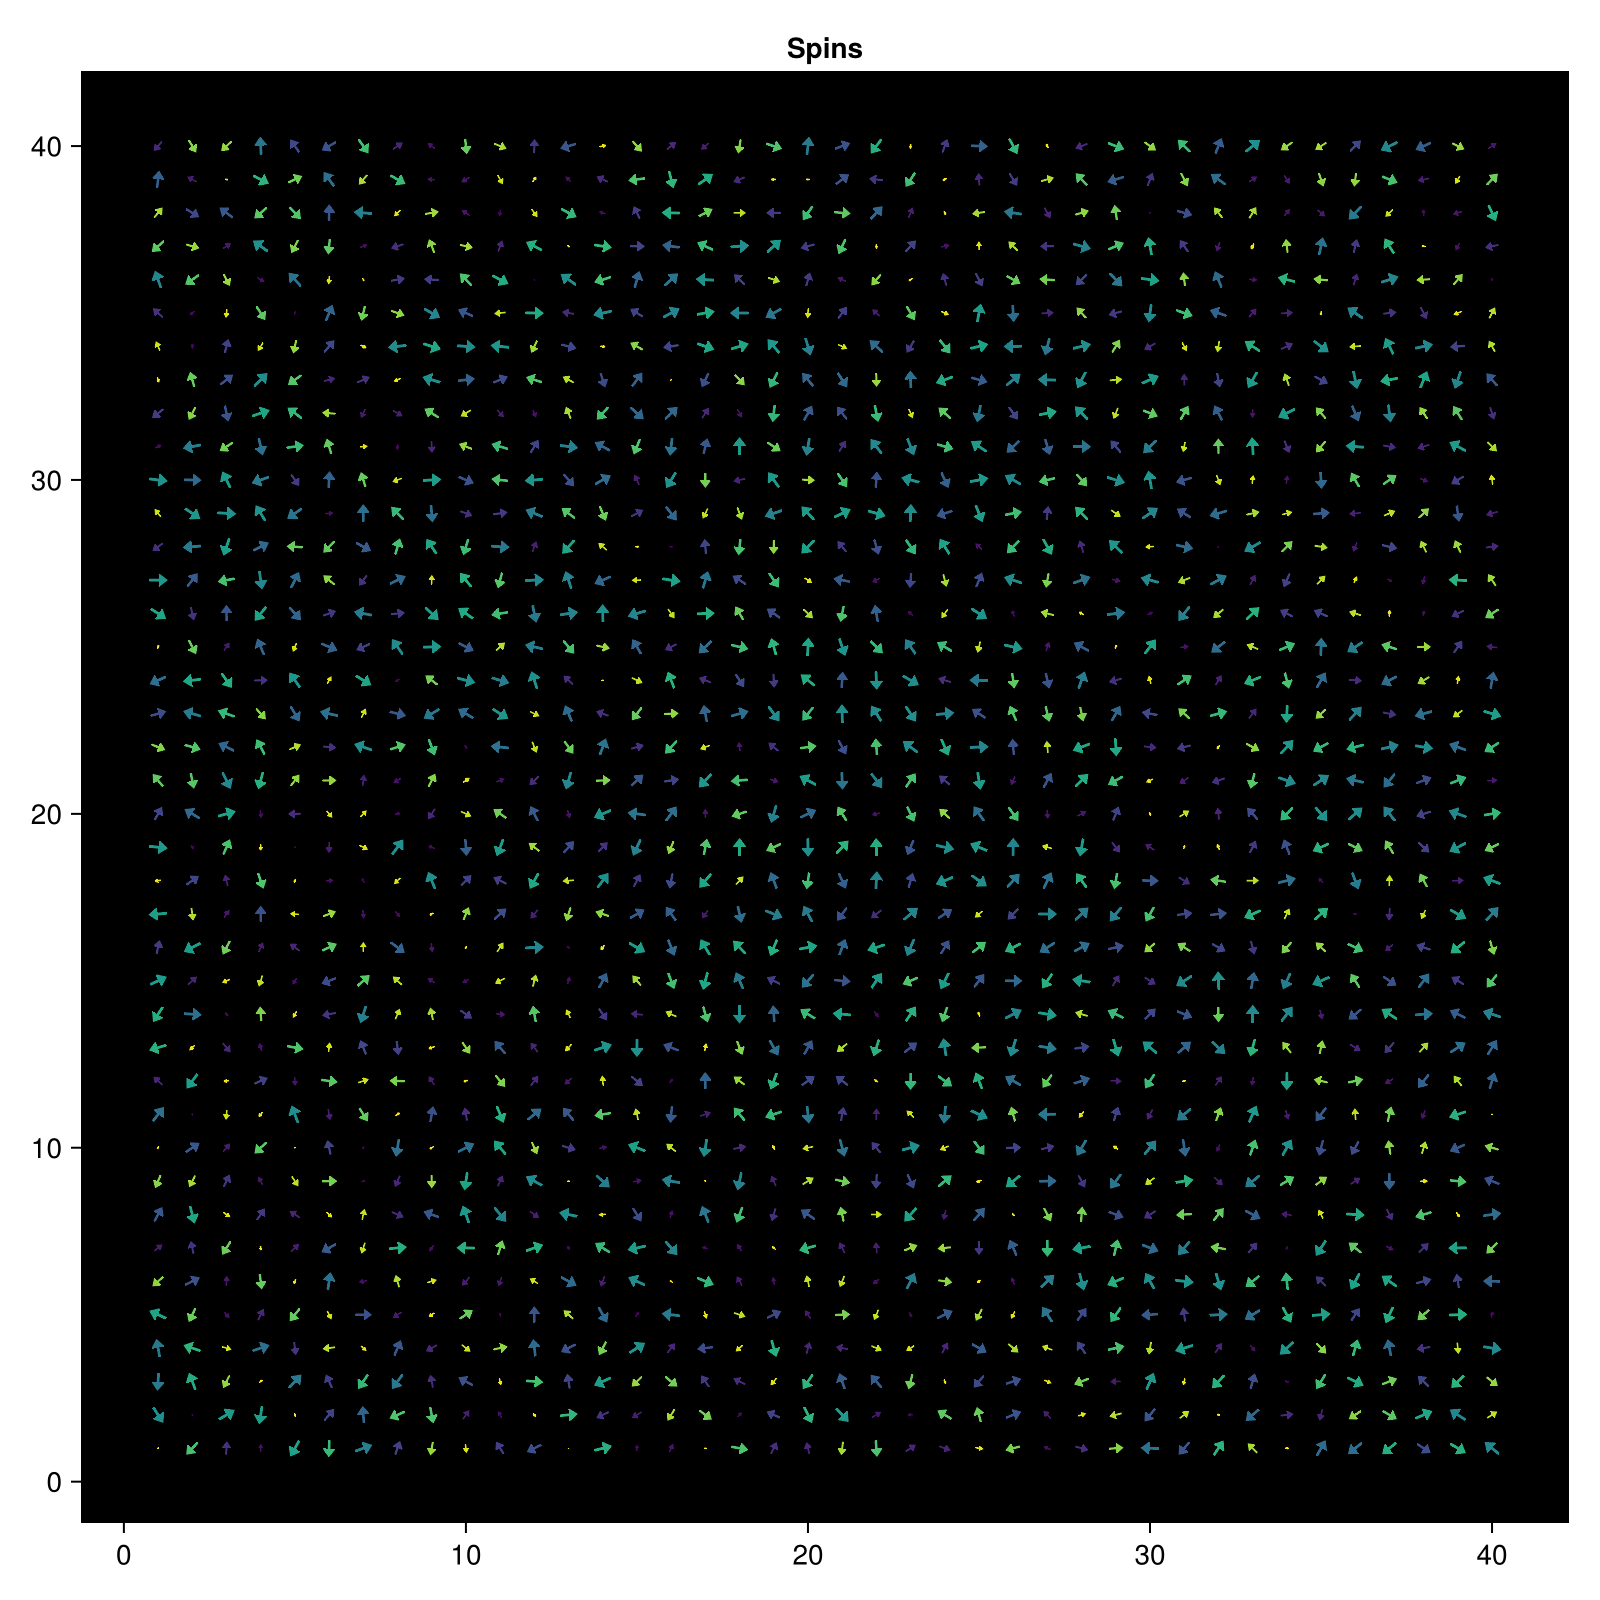

In [31]:
task_no = "21"
file = h5open("../jobs/$jobname.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength, colorrange=(-1,1))
fig

0.8447038139675433

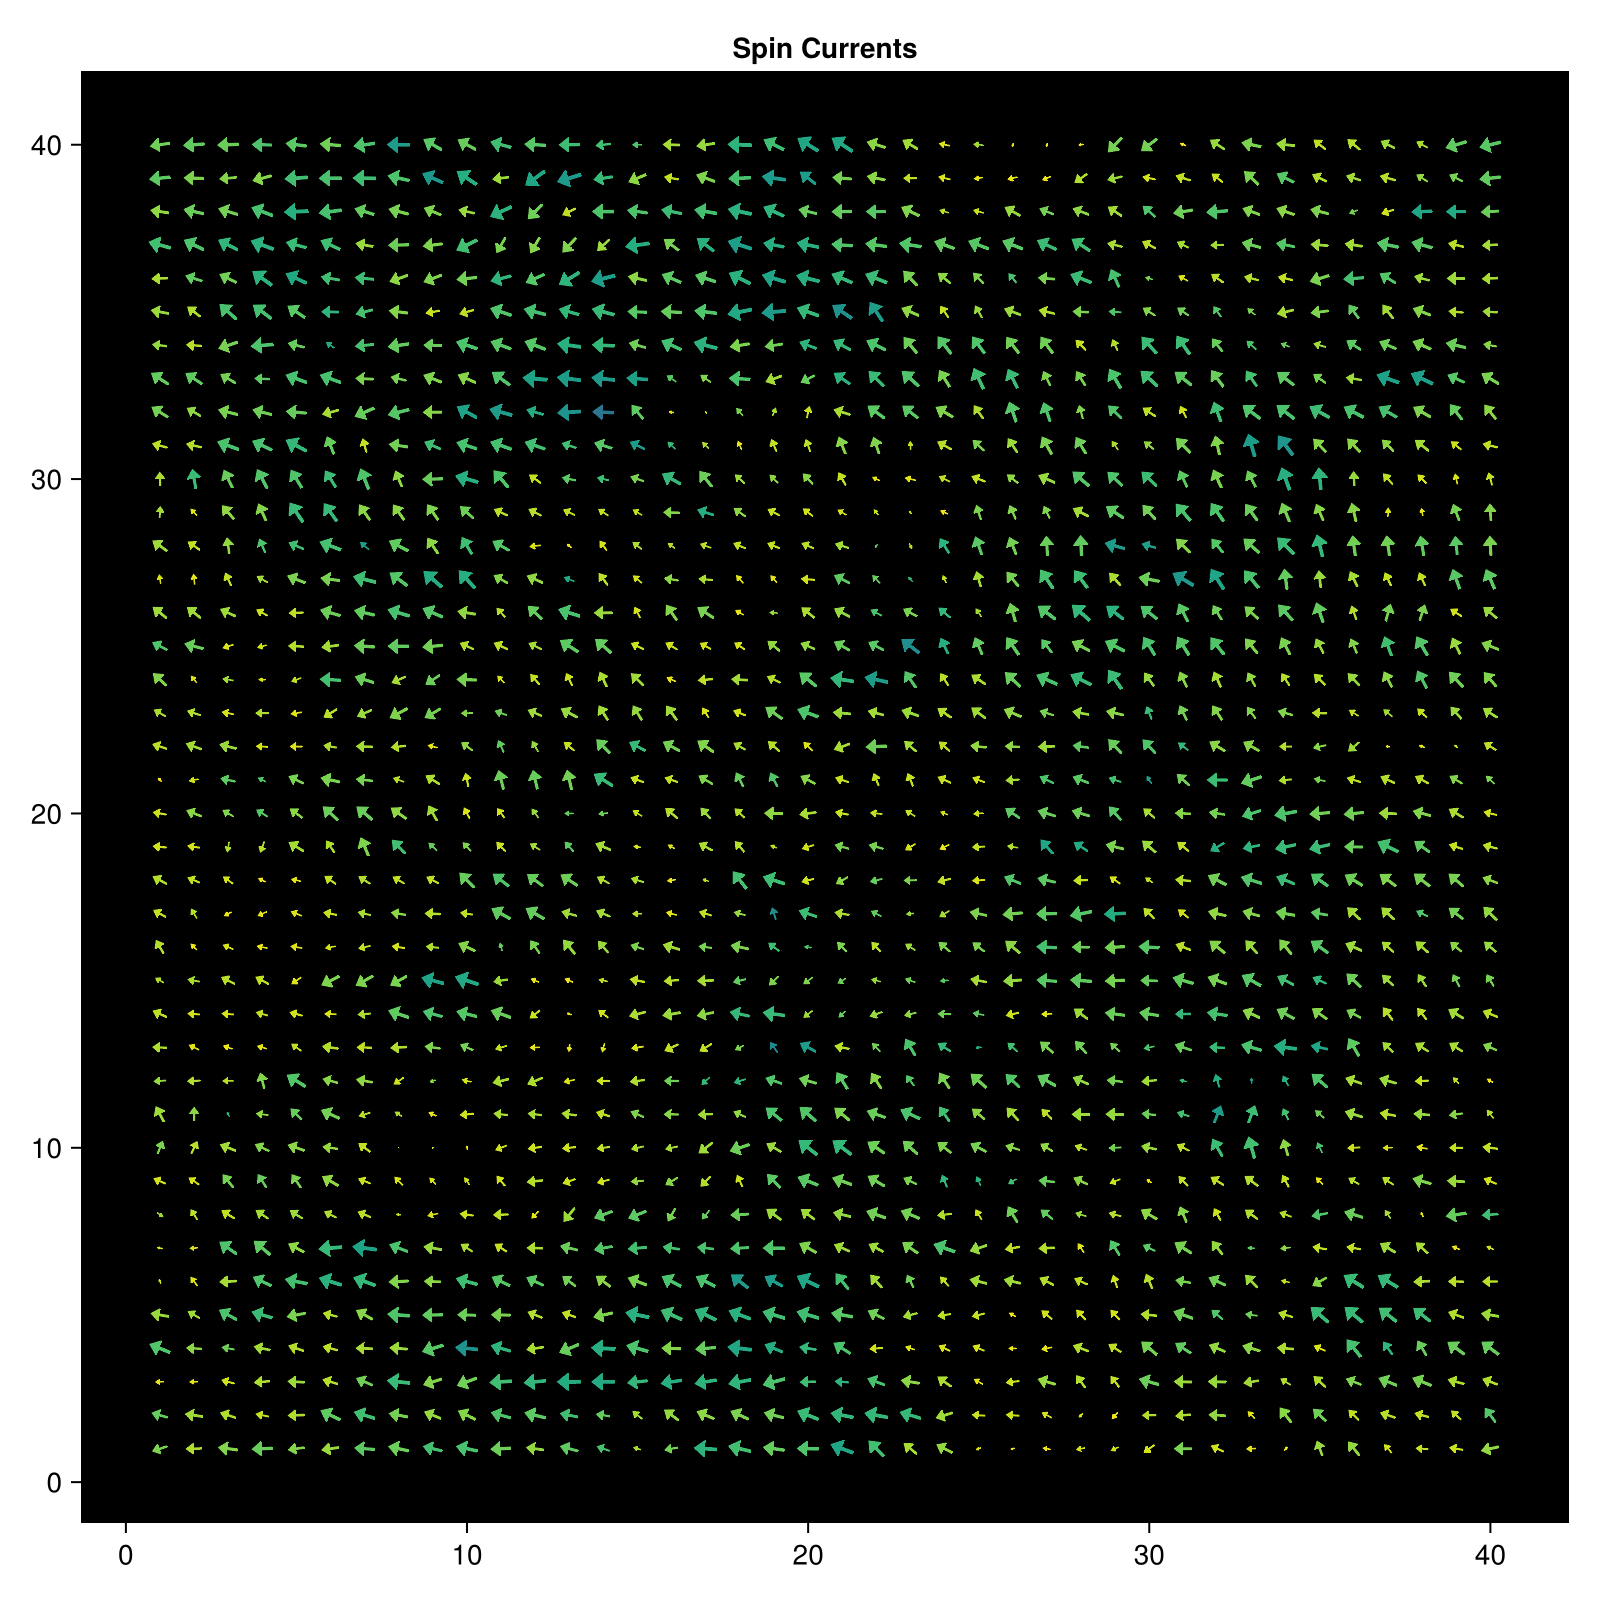

In [66]:
filename = "../jobs/$jobname.data/task$(lpad(i, 4, "0"))/spin-curr.jld"
sweep_no = 50000

fig = Figure(size=(800, 800))
jldopen(filename, "r") do file
    Ps = file["sweep$sweep_no"]
    print(norm(sum(Ps)) / 1600)
    Pxs = map(v -> v[1], Ps)
    Pys = map(v -> v[2], Ps)
    Pzs = map(v -> v[3], Ps)
    strength = vec(Pzs)

    fig[1,1] = Axis(fig; title="Spin Currents", backgroundcolor="black")
    arrows2d!(1:Lx, 1:Ly, Pxs, Pys, lengthscale=0.7, align=:center, color=strength, colorrange=(-1,1))
end

fig